In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def ecdf(data):
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, len(x)+1)/n
    return x,y

In [3]:
sellers_data = pd.read_csv('../input/olist_sellers_dataset.csv')
product_cat = pd.read_csv('../input/product_category_name_translation.csv')
orders_dataset = pd.read_csv('../input/olist_orders_dataset.csv')
order_items_dataset = pd.read_csv('../input/olist_order_items_dataset.csv')
customers_dataset = pd.read_csv('../input/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv('../input/olist_geolocation_dataset.csv')
order_payments_dataset = pd.read_csv('../input/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('../input/olist_order_reviews_dataset.csv')
products_dataset = pd.read_csv('../input/olist_products_dataset.csv')




## Improve ETD accuracy

Improving ETD can be interpreted as:
    1. what is the states that has the lowest time delivery
    2. How does current ETD estimator reflects the true behaviour 

In [4]:
df_all = pd.merge(orders_dataset, customers_dataset, on='customer_id')

In [5]:
df_all['order_purchase_timestamp'] = pd.to_datetime(df_all.order_purchase_timestamp)

In [6]:
clean_data = df_all.dropna()

clean_data['order_approved_at'] = pd.to_datetime(clean_data.order_approved_at)
clean_data['order_delivered_carrier_date'] = pd.to_datetime(clean_data.order_delivered_carrier_date)
clean_data['order_delivered_customer_date'] = pd.to_datetime(clean_data.order_delivered_customer_date)
clean_data['order_estimated_delivery_date'] = pd.to_datetime(clean_data.order_estimated_delivery_date)



convert to date time

In [7]:
clean_data['delta_ord_arrive_time'] = (clean_data.order_delivered_customer_date - clean_data.order_approved_at).dt.days
clean_data['delta_est_ord_arrive_time'] = (clean_data.order_estimated_delivery_date - clean_data.order_approved_at).dt.days
clean_data['delta_true_time_est_time'] = (clean_data.order_delivered_carrier_date - clean_data.order_estimated_delivery_date).dt.days


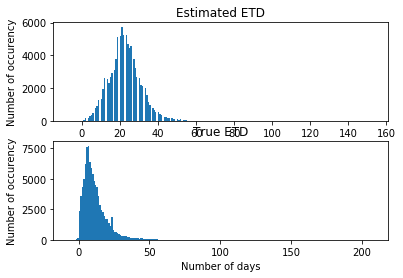

In [8]:
ETD_orders = clean_data.delta_est_ord_arrive_time.tolist()
True_EDT_orders = clean_data.delta_ord_arrive_time.tolist()

plt.subplot(2,1,1)
plt.title('Estimated ETD')
plt.xlabel('Number of days')
plt.ylabel('Number of occurency')
plt.hist(ETD_orders, bins=max(True_EDT_orders))

plt.subplot(2,1,2)
plt.title('True ETD')
plt.xlabel('Number of days')
plt.ylabel('Number of occurency')
plt.hist(True_EDT_orders, bins=max(True_EDT_orders))



plt.show()

It is kindly hard to say anything about this this, let's plot the ECDF for more details
1. how close they are
2. how much does it deviate



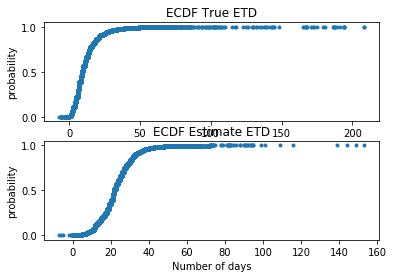

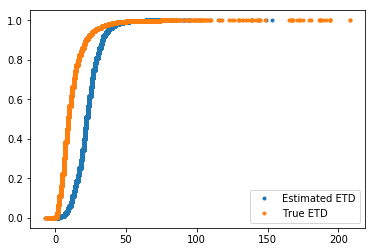

In [9]:
x_est_ETD, y_est_ETD = ecdf(ETD_orders)
x_ETD, y_ETD = ecdf(True_EDT_orders)


plt.plot()

plt.subplot(2,1,1)
plt.title('ECDF True ETD')
plt.xlabel('Number of days')
plt.ylabel('probability')
plt.plot(x_ETD,y_ETD, marker='.', linestyle='none')

plt.subplot(2,1,2)
plt.title('ECDF Estimate ETD')
plt.xlabel('Number of days')
plt.ylabel('probability')
plt.plot(x_est_ETD, y_est_ETD, marker='.', linestyle='none')

plt.show()


plt.plot(x_est_ETD, y_est_ETD, marker='.', linestyle='none')
plt.plot(x_ETD,y_ETD, marker='.', linestyle='none')

plt.legend(['Estimated ETD','True ETD'])
plt.show()




It looks like it is getting the right prediction only when the EST are greater than 40 days with probability of .89. 
But if we look deeper the model, this holds only for a limited number of states, not at all of them 

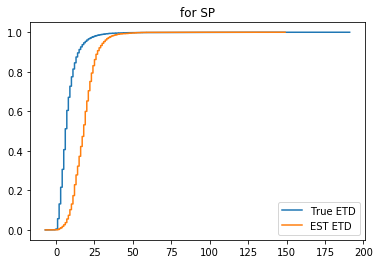

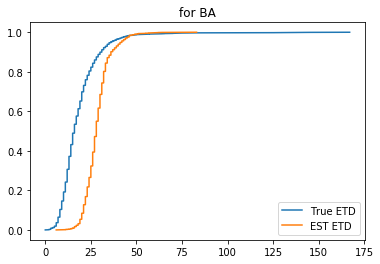

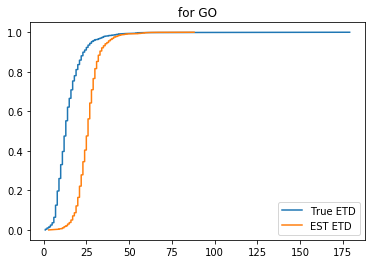

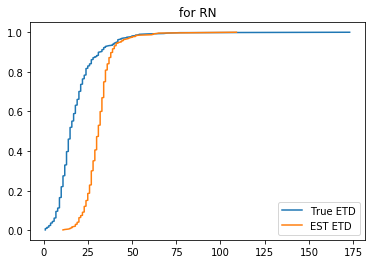

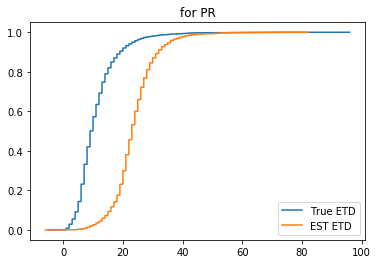

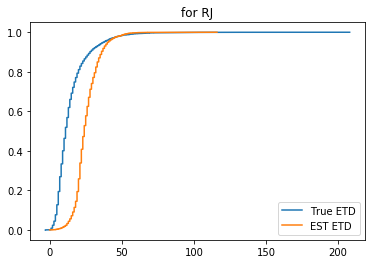

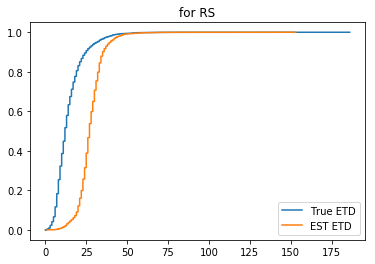

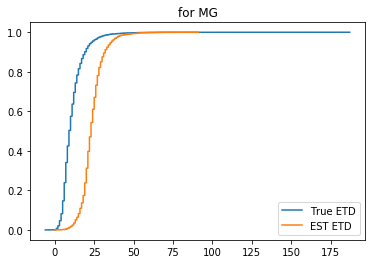

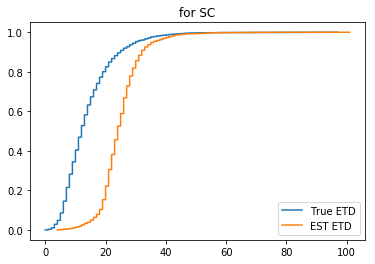

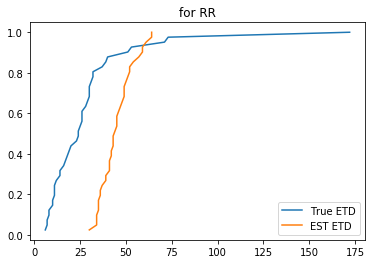

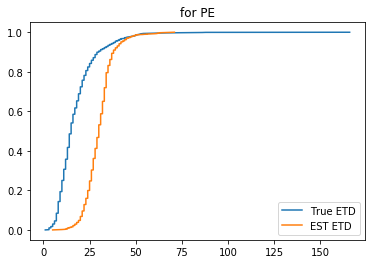

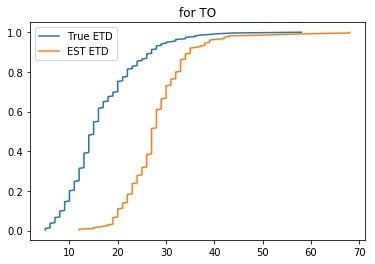

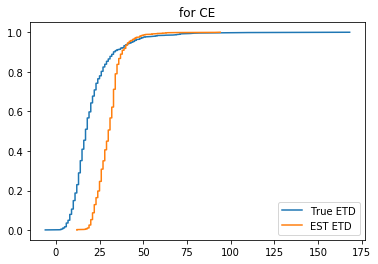

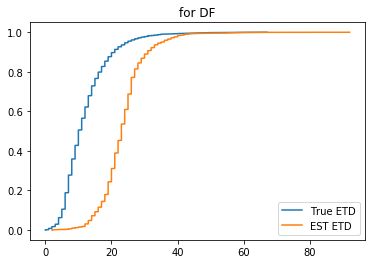

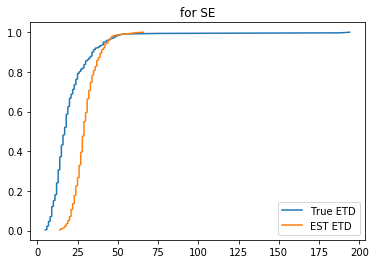

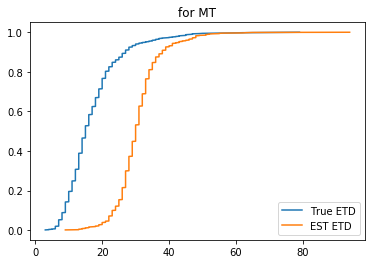

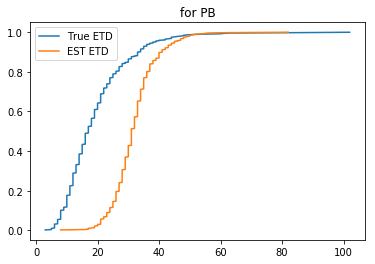

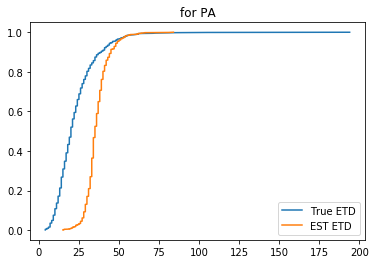

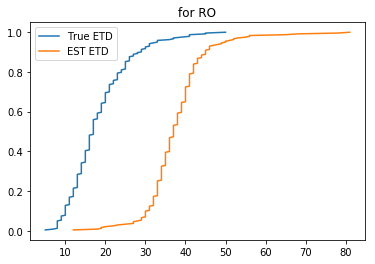

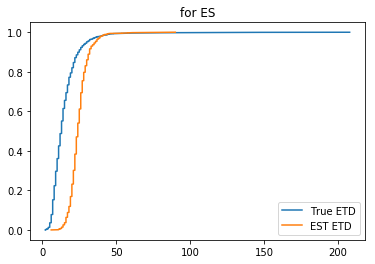

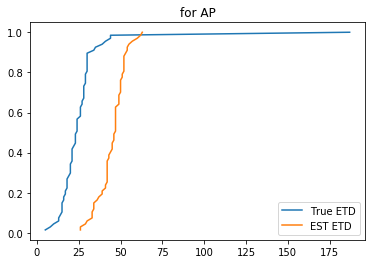

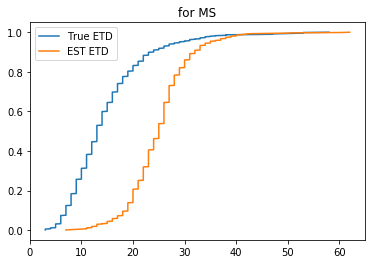

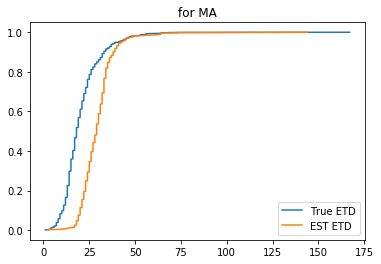

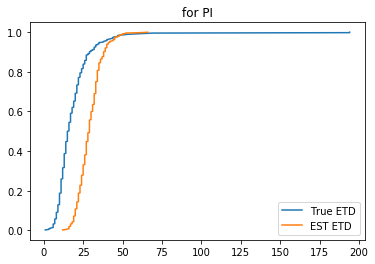

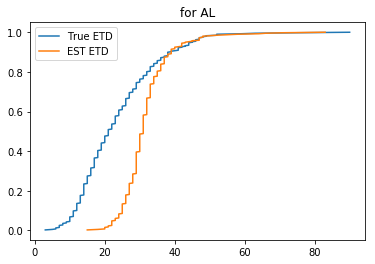

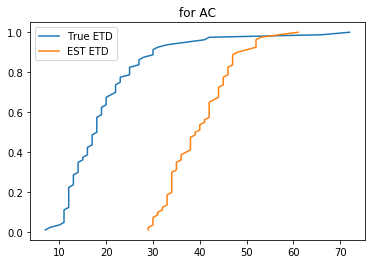

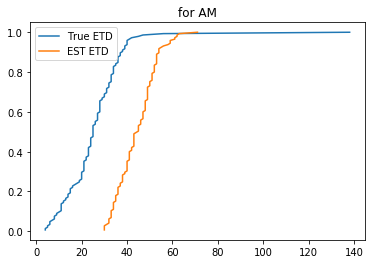

In [69]:
states = clean_data.customer_state.unique().tolist()
figures = []

def plot_ecdf(df):
    ETD_orders = df.delta_est_ord_arrive_time.tolist()
    True_EDT_orders = df.delta_ord_arrive_time.tolist()
    
    x_est_ETD, y_est_ETD = ecdf(ETD_orders)
    x_ETD, y_ETD = ecdf(True_EDT_orders)
    _ = plt.plot(x_ETD, y_ETD)
    _ = plt.plot(x_est_ETD, y_est_ETD)
    _ = plt.title('for {}'.format(df.customer_state.tolist()[-1]))
    _ = plt.legend(['True ETD', 'EST ETD'])
    
    _ = plt.show()
    
    

for s in states:
    plot_ecdf(clean_data[clean_data.customer_state == s])




Lets find those states for whose prediction are almost right, so that we better to know for which of the 

In [60]:
from datetime import datetime

brazillian_holidays = ['January 01', 'March 04', 'March 05', 'March 06', 'April 19', 'April 21',\
           'May 01', 'June 20', 'July 09', 'August 11', 'September 07', 'October 12',\
           'October 25', 'November 02', 'November 15', 'November 20', 'December 25']


brazillian_holidays = [datetime.strptime(_, '%B %d') for _ in brazillian_holidays]

black_friday = ['November 25 2016', 'November 24 2017', 'November 23 2018']
black_friday = [datetime.strptime(_, '%B %d %Y') for _ in black_friday]



In [66]:
len(clean_data[clean_data.delta_ord_arrive_time < 16])

74711

In [67]:
len(clean_data[clean_data.delta_ord_arrive_time > 16])

19286

In [62]:
[datetime.strptime(_, '%B %d %Y') for _ in black_friday]

[datetime.datetime(2016, 11, 25, 0, 0),
 datetime.datetime(2017, 11, 24, 0, 0),
 datetime.datetime(2018, 11, 23, 0, 0)]

In [68]:
clean_data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delta_ord_arrive_time,delta_est_ord_arrive_time,delta_true_time_est_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,8,15,-14
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,12,17,-18
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,9,26,-27
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,13,26,-23
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2,12,-12
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,16,22,-21
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,9,21,-16
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS,8,39,-39
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,299905e3934e9e181bfb2e164dd4b4f8,18075,sorocaba,SP,18,24,-13
10,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,12,21,-20


In [36]:
df_all.order_approved_at.unique().tolist()

['2017-10-02 11:07:15',
 '2018-07-26 03:24:27',
 '2018-08-08 08:55:23',
 '2017-11-18 19:45:59',
 '2018-02-13 22:20:29',
 '2017-07-09 22:10:13',
 '2017-04-13 13:25:17',
 '2017-05-16 13:22:11',
 '2017-01-25 02:50:47',
 '2017-07-29 12:05:32',
 '2017-05-16 19:50:18',
 '2017-07-13 20:10:08',
 '2018-06-09 03:13:12',
 '2018-07-25 17:55:14',
 '2018-03-01 15:10:47',
 '2018-06-12 23:31:02',
 '2018-01-02 19:09:04',
 '2017-12-26 23:50:22',
 '2017-11-21 00:14:22',
 '2017-10-26 16:08:14',
 '2017-09-19 04:04:09',
 '2018-03-15 09:09:31',
 '2018-02-03 20:50:22',
 '2018-01-08 08:07:31',
 '2018-08-10 03:24:51',
 '2018-02-22 02:30:46',
 '2018-06-05 00:35:10',
 '2018-03-12 03:28:34',
 '2018-05-03 12:55:01',
 '2018-02-25 14:47:35',
 '2017-08-12 02:45:24',
 '2018-04-16 22:10:26',
 '2017-12-14 13:54:13',
 '2018-02-03 12:50:30',
 '2018-07-29 23:45:15',
 '2018-02-17 16:15:34',
 '2018-02-23 02:10:52',
 '2017-08-02 02:56:02',
 '2018-06-05 03:35:15',
 '2018-03-26 17:28:27',
 '2017-05-19 19:05:17',
 '2017-11-25 00:

let's try to figure out on which year it has most orders. Here is is clear that

In [ ]:
years = clean_data.order_purchase_timestamp.dt.year.unique().tolist()


orders_2018 = clean_data[clean_data.order_purchase_timestamp.dt.year == 2018]
orders_2017 = clean_data[clean_data.order_purchase_timestamp.dt.year == 2017]
orders_2016 = clean_data[clean_data.order_purchase_timestamp.dt.year == 2016]




# x_2017, y_2017 = ecdf(np.log(orders_2017.order_purchase_days_of_year.tolist()))
# x_2018, y_2018 = ecdf(np.log(orders_2018.order_purchase_days_of_year.tolist()))
# x_2016, y_2016 = ecdf(np.log(orders_2016.order_purchase_days_of_year.tolist()))

x_2017, y_2017 = ecdf(orders_2017.order_purchase_days_of_year.tolist())
x_2018, y_2018 = ecdf(orders_2018.order_purchase_days_of_year.tolist())
x_2016, y_2016 = ecdf(orders_2016.order_purchase_days_of_year.tolist())

plt.plot(x_2016,y_2016, marker='.', linestyle='none')
plt.plot(x_2017, y_2017, marker='.', linestyle='none')
plt.plot(x_2018,y_2018, marker='.', linestyle='none')

plt.show()


##  Pick better fulfillment plans, better meaning "faster" or "cheaper"


In [ ]:
# code goes below
# find the min of time which takes to an item to arrive

## Improve conversion and maximize revenue by dynamically pricing premium delivery options for loyal customers

In [ ]:
# code goes below